In [1]:
import mne
import random
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pywt

from datetime import datetime
from scipy.signal import stft
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import variation, skew, kurtosis 
from scipy.signal import correlate, resample

random.seed(42)

file_paths = [
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_BL_6h.edf', r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_BL_6h.txt'],
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_Dex003(Pharm!)_6h.edf' , r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_Dex003(Pharm!)_6h.txt'],
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_H2O_6h.edf', r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_H2O_6h.txt'],
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_9m_Xyl01(Pharm!)_6h.edf', r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_9m_Xyl01(Pharm!)_6h1.txt'],
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_12m_BL_6h.edf', r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_12m_BL_6h.txt'],
    [r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x6_14m_BL_6h.edf', r'train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x6_14m_BL_6h.txt']
]
class_map = {'def': 0, 'ds1': 1, 'is1': 2, 'swd1': 3, 'sdw1': 3}

In [2]:
class EDFData:
    SAMPLE_RATE = 400

    def __init__(
        self,
        class_map: dict,
        file_paths: str | None,
        neg_aug_sample_ratio: float,
        pos_aug_sample_ratio: float,
        delta_time: int = 1,
        val_ration: float = 0.2,
    ):
        self.class_map = class_map
        self.data = (
            self.read_files(
                file_paths,
                neg_aug_sample_ratio,
                pos_aug_sample_ratio,
                delta_time,
                val_ration,
            )
            if file_paths is not None
            else {"val": [], "train": []}
        )

    def read_files(
        self,
        file_paths: str,
        neg_aug_sample_ratio: float,
        pos_aug_sample_ratio: float,
        delta_time: int,
        val_ration: float,
    ) -> list[list[tuple[np.ndarray, np.ndarray, int]]]:
        datas = {"val": [], "train": []}
        for file_path_edf, file_path_txt in file_paths:
            data = self.read_file(
                file_path_edf,
                file_path_txt,
                neg_aug_sample_ratio,
                pos_aug_sample_ratio,
                delta_time,
                val_ration,
            )
            datas["val"] += data["val"]
            datas["train"] += data["train"]
        # datas['train'] = EDFData.shuffle(datas['train'])
        return datas

    def read_file(
        self,
        file_path_edf: str,
        file_path_txt: str,
        neg_aug_sample_ratio: float,
        pos_aug_sample_ratio: float,
        delta_time: int,
        val_ration: float,
    ) -> list[tuple[np.ndarray, np.ndarray, int]]:
        data = mne.io.read_raw_edf(file_path_edf)
        raw_data = data.get_data()
        labels = pd.read_csv(file_path_txt, delimiter="\t")
        labels["время"] = labels["время"].apply(EDFData.strtime_to_seconds)

        results = {"val": [], "train": []}

        is_val = (
            np.random.uniform(0, 1, size=len(labels["маркер"].iloc[::2])) < val_ration
        )

        results = self.add_data_to_results(
            results,
            raw_data,
            list(
                zip(
                    labels["время"].iloc[::2],
                    labels["время"].iloc[1::2],
                    labels["маркер"].iloc[::2],
                    is_val,
                )
            ),
            delta_time,
        )

        if pos_aug_sample_ratio > 0:
            sampled_positive_intervals = EDFData.sample_random_positive_intervals(
                list(
                    zip(
                        labels["время"].iloc[::2][~is_val],
                        labels["время"].iloc[1::2][~is_val],
                        labels["маркер"].iloc[::2][~is_val],
                    )
                ),
                pos_aug_sample_ratio,
                1,
                10,
            )

            results = self.add_data_to_results(
                results, raw_data, sampled_positive_intervals, delta_time
            )

        if neg_aug_sample_ratio > 0:
            sampled_negative_intervals = EDFData.sample_random_negative_intervals(
                list(zip(labels["время"].iloc[::2], labels["время"].iloc[1::2])),
                neg_aug_sample_ratio,
                2,
                10,
                data.times[-1],
                val_ration,
            )
            results = self.add_data_to_results(
                results, raw_data, sampled_negative_intervals, delta_time
            )

        return results

    def add_data_to_results(
        self,
        results: dict[str, list],
        data: list,
        intervals: list[float],
        delta_time: int,
    ) -> dict[str, list]:
        for start, end, class_, is_val in intervals:
            if end < start:
                continue
            if not is_val:
                raw_data = data[
                    :,
                    int(
                        self.SAMPLE_RATE * (start - random.uniform(0, delta_time))
                    ) : int(self.SAMPLE_RATE * (end + random.uniform(0, delta_time))),
                ]
                results["train"] += [
                    (self.feature_data(raw_data), self.class_map[class_])
                ]
            else:
                raw_data = data[
                    :, int(self.SAMPLE_RATE * start) : int(self.SAMPLE_RATE * end)
                ]
                results["val"] += [
                    (self.feature_data(raw_data), self.class_map[class_])
                ]
        return results

    def feature_data(self, raw_data: np.ndarray) -> np.ndarray:
        means = np.mean(raw_data, axis=1)
        median = np.median(raw_data, axis=1)
        sigmas = np.std(raw_data, axis=1)
        percentile95 = np.percentile(raw_data, q=0.95, axis=1)
        percentile05 = np.percentile(raw_data, q=0.05, axis=1)
        percentile75 = np.percentile(raw_data, q=0.75, axis=1)
        percentile35 = np.percentile(raw_data, q=0.35, axis=1)
        cv = np.std(raw_data, ddof=1, axis=1) / np.mean(raw_data, axis=1)
        sk = skew(raw_data, axis=1, bias=True)
        kurt = kurtosis(raw_data, axis=1, bias=True)
        fourie_means = self.extract_fft_features_fixed_freqs(raw_data)[0].flatten()
        return np.concatenate(
            (means, median, sigmas, percentile95, percentile05, percentile75, percentile35, lyapunov, cv, sk, kurt, fourie_means, corr), axis=0
        )

    def get_cwt_coefficients(
        self, signal: np.ndarray, dt: float = 1 / 400, scales: np.ndarray | None = None
    ):
        """
        Получить коэффициенты разложения CWT для одномерного сигнала.

        signal: ndarray
            Входной одномерный сигнал.

        dt: float
            Период дискретизации (частота дискретизации), по умолчанию 1/400 (400 Гц).

        scales: ndarray
            Масштабы (scales) для CWT, если не переданы, используются значения по умолчанию.
        """
        if scales is None:
            scales = np.arange(1, 128)  # Масштабы для CWT по умолчанию

        coefficients, freqs = pywt.cwt(
            signal, scales, "cmor1.5-1.0", sampling_period=dt
        )

        return coefficients, freqs

    def extract_fft_features_fixed_freqs(
        self,
        raw_data: np.ndarray,
        sample_rate: int = 400,
        target_freqs: npt.ArrayLike | None = None,
    ) -> tuple[np.ndarray, np.ndarray]:
        raw_data = np.asarray(raw_data)

        if target_freqs is None:
            target_freqs = np.arange(0.01, 25.1, 0.01)
        else:
            target_freqs = np.asarray(target_freqs)
        N = raw_data.shape[1]
        freqs = np.fft.rfftfreq(N, d=1.0 / sample_rate)
        features = []
        for channel_data in raw_data:
            fft_values = np.fft.rfft(channel_data)
            fft_magnitudes = np.abs(fft_values)
            interpolated_magnitudes = np.interp(target_freqs, freqs, fft_magnitudes)
            features.append(interpolated_magnitudes)

        features = np.array(features)
        return features, target_freqs
    
    @staticmethod
    def strtime_to_seconds(time_str: str) -> int:
        time_obj = datetime.strptime(time_str, "%H:%M:%S")
        total_seconds = time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
        return total_seconds

    @staticmethod
    def sample_random_negative_intervals(
        intervals: list[float],
        aug_neg_ratio: float,
        min_length: int,
        max_length: int,
        max_time: int,
        val_ration: float,
    ):

        intervals = sorted(intervals, key=lambda x: x[0])

        available_intervals = []
        current_time = 0.0
        if intervals[0][0] - current_time >= min_length:
            available_intervals.append([current_time, intervals[0][0]])

        for i in range(len(intervals) - 1):
            gap_start = intervals[i][1]
            gap_end = intervals[i + 1][0]
            if gap_end - gap_start >= min_length:
                available_intervals.append([gap_start, gap_end])

        if max_time is not None:
            last_interval_end = intervals[-1][1]
            if max_time - last_interval_end >= min_length:
                available_intervals.append([last_interval_end, max_time])

        sampled_intervals = []
        attempts = 0
        max_attempts = 1000
        N = int(aug_neg_ratio * len(intervals))
        while len(sampled_intervals) < N and attempts < max_attempts:
            attempts += 1

            gap = random.choice(available_intervals)
            gap_start, gap_end = gap
            gap_length = gap_end - gap_start

            if gap_length < min_length:
                continue

            start_time = random.uniform(gap_start, gap_end - min_length)

            max_interval_length = min(gap_end - start_time, max_length)
            interval_length = random.uniform(min_length, max_interval_length)

            end_time = start_time + interval_length

            sampled_intervals.append(
                (start_time, end_time, "def", np.random.uniform(0, 1) < val_ration)
            )

        return sampled_intervals

    @staticmethod
    def sample_random_positive_intervals(
        intervals: list[float], aug_pos_ratio: float, min_length: int, max_length: int
    ):

        sampled_intervals = []
        attempts = 0
        max_attempts = 1000
        N = int(aug_pos_ratio * len(intervals))
        while len(sampled_intervals) < N and attempts < max_attempts:
            attempts += 1

            gap = random.choice(intervals)
            gap_start, gap_end, class_ = gap
            gap_length = gap_end - gap_start

            if gap_length < min_length:
                continue

            start_time = random.uniform(gap_start, gap_end - min_length)

            max_interval_length = min(gap_end - start_time, max_length)
            interval_length = random.uniform(min_length, max_interval_length)

            end_time = start_time + interval_length

            sampled_intervals.append((start_time, end_time, class_, 0))

        return sampled_intervals

    @staticmethod
    def shuffle(data: list) -> list:
        return random.shuffle(data)


In [17]:
test_data = EDFData(class_map, file_paths, neg_aug_sample_ratio = 2.0, pos_aug_sample_ratio = 1.0)

Extracting EDF parameters from c:\Users\bende\Projects\VScodeProjects\hacathon_mejnar\train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_BL_6h.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\bende\Projects\VScodeProjects\hacathon_mejnar\train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_Dex003(Pharm!)_6h.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\bende\Projects\VScodeProjects\hacathon_mejnar\train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x1_15m_H2O_6h.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from c:\Users\bende\Projects\VScodeProjects\hacathon_mejnar\train_dataset\ECoG_fully_marked_(4+2 files, 6 h each)\Ati4x3_9m_Xyl01(Pharm!)_6h.edf...
EDF file detected
Setting channel info structure...
Creating raw.info st

In [18]:
Xtrain, ytrain = zip(*test_data.data['train'])
Xval, yval = zip(*test_data.data['val'])

In [19]:
Xtrain, ytrain = np.array(Xtrain), np.array(ytrain)
Xval, yval = np.array(Xval), np.array(yval)

In [21]:
from catboost import CatBoostClassifier, Pool

train_pool = Pool(Xtrain, ytrain)
test_pool = Pool(Xval, yval)

In [ ]:
model = CatBoostClassifier(
    iterations=6000,
    learning_rate=0.01,
    loss_function='MultiClass',
    verbose=100,
    random_seed=42,
    task_type="GPU",
    devices='0'
)

model.fit(train_pool, eval_set=test_pool)

0:	learn: 1.3720483	test: 1.3698095	best: 1.3698095 (0)	total: 131ms	remaining: 13m 6s
100:	learn: 0.7583941	test: 0.6751526	best: 0.6751526 (100)	total: 11.3s	remaining: 10m 59s
200:	learn: 0.5775499	test: 0.5032340	best: 0.5032340 (200)	total: 22.6s	remaining: 10m 52s
300:	learn: 0.4865345	test: 0.4402853	best: 0.4402853 (300)	total: 34.4s	remaining: 10m 51s
400:	learn: 0.4287940	test: 0.4123979	best: 0.4123979 (400)	total: 45.2s	remaining: 10m 31s
500:	learn: 0.3853123	test: 0.3972698	best: 0.3972698 (500)	total: 55.8s	remaining: 10m 12s
600:	learn: 0.3501375	test: 0.3879675	best: 0.3879305 (599)	total: 1m 6s	remaining: 9m 55s
700:	learn: 0.3210372	test: 0.3823455	best: 0.3823455 (700)	total: 1m 16s	remaining: 9m 40s
800:	learn: 0.2959688	test: 0.3772703	best: 0.3772676 (798)	total: 1m 27s	remaining: 9m 26s
900:	learn: 0.2740128	test: 0.3725513	best: 0.3725513 (900)	total: 1m 38s	remaining: 9m 15s
1000:	learn: 0.2549232	test: 0.3698547	best: 0.3697734 (992)	total: 1m 48s	remaining: 

In [23]:
y_pred = model.predict(Xval)

In [24]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

f1_score(yval, y_pred, average='macro')

0.8593808417337828

In [120]:
accuracy_score(yval, y_pred)

0.8163265306122449

In [121]:
recall_score(yval, y_pred, average='macro')

0.8926603963721867

In [122]:
model.save_model(r'models/catboost_5k_25hz_weighted.cbm',
           format="cbm",
           export_parameters=None,
           pool=None)

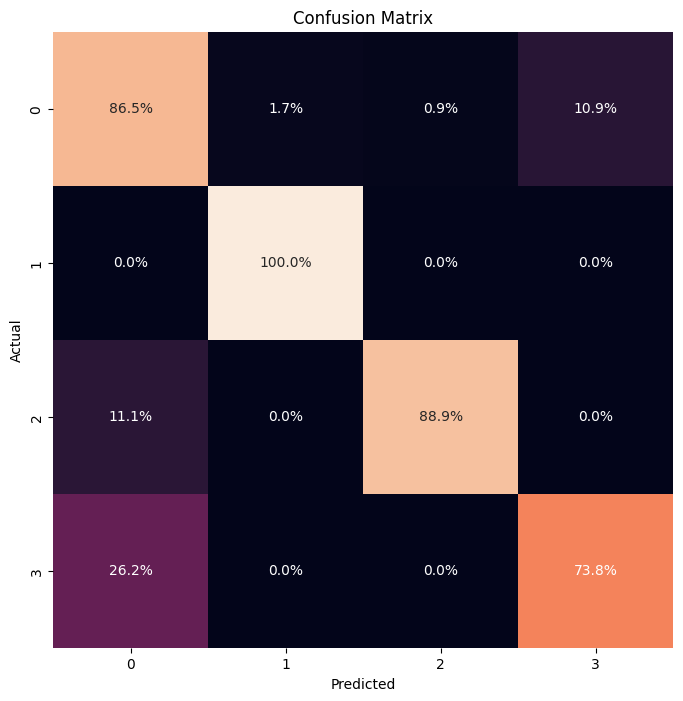

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(yval, y_pred, normalize='true')
figsize = (8,8)

fig, ax = plt.subplots(figsize=figsize)
plt.title('Confusion Matrix')
hmap = sns.heatmap(cm, ax=ax, annot=True, fmt='.1%', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()